In [1]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
import seaborn as sns
from wordcloud import WordCloud
from scipy.stats import kruskal
from collections import Counter
import re
# %matplotlib inline

# 분석 결과 요약
- testset 제외하고 train, dev 데이터셋 살펴봄
1. 데이터 기본 특성
    1. 전체 데이터 크기: train 9324, dev 550
        1. ***Q. train과 dev 섞어서 k-fold 해도 되는지? test만 안건드리면 되는건지?***
    2. 컬럼별 데이터 타입 확인: object(id, source, sentence_1, sentence2), float64(label, binary-label)
        1. source와 binary-label은 category로 dtype 변경하는게 나을 것
    3. 결측치 확인: 결측치 없음
    4. 중복 데이터 확인: train 데이터의 sentence_2에 중복 문자열 3쌍 존재 (무시 가능한 수준)
2. dtype별 분석
    1. 범주형 컬럼: source, binary-label
        1. source: slack 데이터에서 RTT 비율이 조금 높긴 하지만, 이들 합쳐서는 3개 source에서 데이터 고르게 분포하고 있음
        2. binary-label: train은 binary 0에 라벨 밀집 / dev는 1이 더 많음
    2. 수치형 컬럼: label
        1. train 데이터의 값 중 다수가 0 값 갖는 경향 확인 (binary-label에서 확인된 내용과 동일)
            1. label == 0: 2119건 (22.7%)
            2. 0 <= label < 0.25: 2464건 (26.4%)
        2. 따라서 ***train 데이터에서 0보다 큰 유사도 값을 갖는 데이터 쌍을 고르게 더 증강할 필요 있음. (how..?)***
    3. 문자형 컬럼: sentence_1, sentence_2
        1. 글자 수: median 20, 50글자 초과하는 문장 비율 평균 6%
        2. 단어 수: median 5, 13단어 초과하는 문장 비율 평균 4%
        3. 글자 수, 단어 수 모두에서 sentence_1과 sentence_2 간의 높은 상관(0.8)
            1. 즉, 긴 문장은 긴 문장과, 짧은 문장은 짧은 문장과 비교되는 경향 존재
            2. ***글자수, 단어수 이상치(50자 초과, 13개 단어 이상) 데이터 텍스트 살펴봤을 때, 납득할만한 내용과 길이이므로 truncation 없이 그대로 사용하는게 나아보임 (문장 잘라낼정도로 길지는 않아보임)***
        4. 자주 등장하는 단어
            1. ㅋㅋ, ㅎㅎ, ㅠㅠ 등 자주 등장
            2. 데이터 특성상 영화, 청원합니다, 청와대, 것 같아요, ~님과 등의 표현 자주 등장
                1. ***영화, 정치, 업무 등과 관련된 데이터 이용한 pre-trained model 고려해보면 좋을 듯 (찾을 수 있길..)***
            3. 전처리 시 필터링할 단어 종류 및 특성은 좀 더 살펴봐야 할 것 같음 (맞춤법 파괴 케이스, 신조어 사용 빈도 등..)
        5. 특수문자, 영어, 한글 데이터 비율
            1. 특수문자: 19.23% (영어, 한국어 아닌 모든 문자. 숫자 포함. ㅋㅋ 등도 포함)
            2. 영어: 0.64%
            3. 한글: 80.13%
            4. '합니다.' 등도 '.'때문에 특수문자로 분류된 상황이긴 함.. ***전처리 시에 이런 특수문자 어떻게 처리할지 고민 필요***
3. source별 분석
    1. source별 label 분포
        1. sampled는 label 작고 (median 1~2), rtt는 label 큼 (median 3~4)
        2. sampled+rtt로 source 병합하면 균형 맞는듯
        3. ***sampled와 rtt 병합해서 구분 없이 source 사용하는게 나을 듯***
    2. source별 sentence 특성 (dtype별 분석에서 모든 문자 대해 진행한 것들을 source별로 확인) - 미진행
        1. 문장 길이 분포 및 이상치
        2. 단어 수 분포 및 이상치
        3. 단어 종류별 분포
        4. 기타 정성적 분석
        5. source별로 내용 이외에 (문장 길이, 단어 수, 단어 종류 분포 등) 큰 차이 없기를 바라고, 아마 그럴 것 같긴 한데, 한번 ***확인은 필요***할듯. 만약 큰 차이 없다면, 도메인 내용만 고려해 학습 진행해도 되지만, 분포에 큰 차이 있으면 학습 과정에서 case 나눠 처리해야 할 수도.
4. label별 데이터 특성
    1. 점수대별로 나눠서 sentence_1과 sentence_2의 유사도 확인해보니, 다음 기준에 따르고 있음 확인됨
        - 5점 : 두 문장의 핵심 내용이 동일하며, 부가적인 내용들도 동일함
        - 4점 : 두 문장의 핵심 내용이 동등하며, 부가적인 내용에서는 미미한 차이가 있음
        - 3점 : 두 문장의 핵심 내용은 대략적으로 동등하지만, 부가적인 내용에 무시하기 어려운 차이가 있음
        - 2점 : 두 문장의 핵심 내용은 동등하지 않지만, 몇 가지 부가적인 내용을 공유함
        - 1점 : 두 문장의 핵심 내용은 동등하지 않지만, 비슷한 주제를 다루고 있음
        - 0점 : 두 문장의 핵심 내용이 동등하지 않고, 부가적인 내용에서도 공통점이 없음

5. 기타 질문
    - 각 sentence는 한 문장으로만 구성돼있나? 만약 아니라면, 비교 대상이 되는 문장도 동일한 개수의 문장?

# 0. 기본 설정
- 작업 디렉토리 설정
- 폰트 지정: 이미지에서 한글 깨짐 방지 위함
- 데이터 불러오기: `train.csv`, `dev.csv`

In [2]:
# 작업 디렉토리 설정
print(os.getcwd())  # 현재 작업 디렉토리 조회
os.chdir("/data/ephemeral/home/level1-semantictextsimilarity-nlp-06/eda") # 작업 디렉토리 변경

/data/ephemeral/home/level1-semantictextsimilarity-nlp-06/eda


In [3]:
# 폰트 지정
!apt-get -qq install fonts-nanum
font_path = "/usr/share/fonts/truetype/nanum/NanumBarunGothic.ttf" # wordcloud에서 한글 깨짐 현상 방지
font_name = fm.FontProperties(fname=font_path).get_name()
plt.rc('font', family=font_name)
# plt.rc('font', family='NanumBarunGothic')  # plt에서 한글 깨짐 현상 방지 (서버)
# plt.rcParams['font.family'] = 'AppleGothic'  # plt에서 한글 깨짐 현상 방지 (local 환경)
plt.rcParams['axes.unicode_minus'] = False


In [4]:
# 데이터 불러오기
data_train = pd.read_csv("../data/train.csv")
data_dev = pd.read_csv("../data/dev.csv")

In [5]:
data_train.head()

,id,source,sentence_1,sentence_2,label,binary-label
0,boostcamp-sts-v1-train-000,nsmc-sampled,스릴도있고 반전도 있고 여느 한국영화 쓰레기들하고는 차원이 다르네요~,"반전도 있고,사랑도 있고재미도있네요.",2.2,0.0
1,boostcamp-sts-v1-train-001,slack-rtt,앗 제가 접근권한이 없다고 뜹니다;;,"오, 액세스 권한이 없다고 합니다.",4.2,1.0
2,boostcamp-sts-v1-train-002,petition-sampled,주택청약조건 변경해주세요.,주택청약 무주택기준 변경해주세요.,2.4,0.0
3,boostcamp-sts-v1-train-003,slack-sampled,입사후 처음 대면으로 만나 반가웠습니다.,화상으로만 보다가 리얼로 만나니 정말 반가웠습니다.,3.0,1.0
4,boostcamp-sts-v1-train-004,slack-sampled,뿌듯뿌듯 하네요!!,꼬옥 실제로 한번 뵈어요 뿌뿌뿌~!~!,0.0,0.0


In [6]:
data_dev.head()

,id,source,sentence_1,sentence_2,label,binary-label
0,boostcamp-sts-v1-dev-000,nsmc-sampled,액션은개뿔 총몇번쏘고 끝입니다,액션은 흉내만 내고 그마저도 후반부에는 슬로우모션 처리,2.0,0.0
1,boostcamp-sts-v1-dev-001,slack-rtt,감격스러워 입막으심?,너무 감동해서 입 다물어?,3.4,1.0
2,boostcamp-sts-v1-dev-002,nsmc-rtt,이번 년도에 본 영화 중 가장 최악의 영화......,올해 본 영화 중 최악...,4.0,1.0
3,boostcamp-sts-v1-dev-003,slack-rtt,특히 평소 뮤직채널에 많은 영감을 불어넣어주시는!,"특히, 당신은 항상 많은 음악 채널에 영감을 줍니다!",3.4,1.0
4,boostcamp-sts-v1-dev-004,slack-sampled,다음 밥스테이지가 기대됩니다~ ㅎ,다음 후기도 기대됩니다~~,1.4,0.0


# 1. 데이터 기본 특성
- 전체 데이터 크기
- 컬럼별 데이터 타입 확인
- 결측치 확인
- 중복 데이터 확인

#### 함수 정의

In [7]:
# 결측치 확인 함수
def missing_data_analysis(df):
    total_missing = df.isnull().sum()
    percent_missing = 100 * total_missing / len(df)
    missing_df = pd.DataFrame({'Total Missing': total_missing, 'Percentage': percent_missing})
    return missing_df

#### 분석

In [8]:
# 전체 데이터 크기
print("[전체 데이터 크기] ".ljust(60, '-'))
print(f"train 데이터 크기: {data_train.shape}")  # (9324, 6)
print(f"dev 데이터 크기: {data_dev.shape}\n")      # (550, 6)
### Q. train과 dev 섞어서 k-fold 해도 되는지? test만 안건드리면 되는건지?

# 컬럼별 데이터 타입 확인
print("[컬럼별 데이터 타입] ".ljust(60, '-'))
print(data_train.dtypes, "\n")   # train, dev 동일
# pandas는 string을 object 형식으로 지정함
# source, binary-label은 categorical로 변경해줘야 하지 않으려나?

# source, binary-label 데이터 형식 변경 (object, float64 -> categorical)
data_train = data_train.astype({'binary-label':'int8'})  # 0.0, 1.0을 0,1으로 변환
data_train = data_train.astype({'source':'category', 'binary-label':'category'})  # 범주형 데이터로 변환
data_dev = data_dev.astype({'binary-label':'int8'})
data_dev = data_dev.astype({'source':'category', 'binary-label':'category'})

# 변경된 컬럼별 데이터 타입 확인
print("[컬럼별 데이터 타입 (변경됨)] ".ljust(60, '-'))
print(data_train.dtypes)   # train, dev 동일

[전체 데이터 크기] ------------------------------------------------
train 데이터 크기: (9324, 6)
dev 데이터 크기: (550, 6)

[컬럼별 데이터 타입] -----------------------------------------------
id               object
source           object
sentence_1       object
sentence_2       object
label           float64
binary-label    float64
dtype: object 

[컬럼별 데이터 타입 (변경됨)] -----------------------------------------
id                object
source          category
sentence_1        object
sentence_2        object
label            float64
binary-label    category
dtype: object


In [9]:
# 결측치 확인
print("[컬럼별 결측치 확인] ".ljust(60, '-'))
print(data_train.isnull().sum(axis=0), "\n")  # train, dev 모두 모든 칼럼에 결측치 없음

# 중복 데이터 있는지 확인
print("[중복행 여부 확인] ".ljust(60, '-'))
print(f"train 전체 중복 행 개수: {len(data_train[data_train.duplicated(keep=False)])}") # 행이 완전이 동일한 중복 데이터는 없음
print(f"dev 전체 중복 행 개수: {len(data_dev[data_dev.duplicated(keep=False)])}")
print(f"train sentence_1 중복 행 개수: {len(data_train[data_train.duplicated(subset='sentence_1', keep=False)])}") # 0
print(f"train sentence_2 중복 행 개수: {len(data_train[data_train.duplicated(subset='sentence_2', keep=False)])}") # 6
print(f"dev sentence_1 중복 행 개수: {len(data_dev[data_dev.duplicated(subset='sentence_1', keep=False)])}")       # 0
print(f"dev sentence_2 중복 행 개수: {len(data_dev[data_dev.duplicated(subset='sentence_2', keep=False)])}")       # 0

# train셋의 sentence_2에 중복행 조희
data_train[data_train.duplicated(subset='sentence_2', keep=False)].sort_values(by="sentence_2", ascending=True)
# 약 9300건 중 6건이니, 별도로 제거할 필요는 없을 듯.

[컬럼별 결측치 확인] -----------------------------------------------
id              0
source          0
sentence_1      0
sentence_2      0
label           0
binary-label    0
dtype: int64 

[중복행 여부 확인] ------------------------------------------------
train 전체 중복 행 개수: 0
dev 전체 중복 행 개수: 0
train sentence_1 중복 행 개수: 0
train sentence_2 중복 행 개수: 6
dev sentence_1 중복 행 개수: 0
dev sentence_2 중복 행 개수: 0


,id,source,sentence_1,sentence_2,label,binary-label
173,boostcamp-sts-v1-train-173,slack-rtt,다음에 다시 재밌는 이야기해요!,다음에 또 즐겁게 이야기합시다!,3.6,1
6540,boostcamp-sts-v1-train-6540,slack-rtt,다음에 또 즐겁게 이야기 나누어요!,다음에 또 즐겁게 이야기합시다!,4.4,1
601,boostcamp-sts-v1-train-601,slack-rtt,다음에 또 뵈어요!,다음에 만나요!,4.0,1
8520,boostcamp-sts-v1-train-8520,slack-rtt,다음에 꼭 뵈어요!,다음에 만나요!,3.4,1
4523,boostcamp-sts-v1-train-4523,petition-rtt,청소년보호법 폐지요,청소년보호법 폐지해주세요,4.0,1
4706,boostcamp-sts-v1-train-4706,petition-rtt,청소년 보호법 폐지 부탁드립니다,청소년보호법 폐지해주세요,4.2,1


# 2. `dtype`별 분석
- 범주형 컬럼 (`source`, `binary-label`): 분포
- 수치형 컬럼 (`label`): 분포, 평균, 중앙값, 표준편차, 최소값, 최대값 등
- 문자형 컬럼 (`sentence_1`, `sentence_2`): 문장 길이 분포, 단어 수 분포, 최빈 단어, 문자 종류별 분포(한글/영어/특수문자), 기타 정성적 분석

#### 함수 정의

In [10]:
# source별 개수 확인
def source_count(df):
    df[['source_name', 'type']] = df['source'].str.split('-', expand=True)  # 'source' 열을 분리하여 source_name과 type 생성
    result = df.groupby(['source_name', 'type']).size().unstack(fill_value=0)  # 데이터 집계
    result['sum'] = result.sum(axis=1)  # 'sum' 열 추가
    total_sum = result['sum'].sum()
    result['prop'] = round(result['sum'] / total_sum, 2) # 'prop' 열 추가
    result = result.reindex(columns=['sampled', 'rtt', 'sum', 'prop'])  # 열 순서 조정 및 인덱스 정렬
    result = result.reindex(['petition', 'nsmc', 'slack'])
    return result

# source별 누적 막대그래프 시각화
def source_stacked_bar(result_df, title, ax):
    result_df[['sampled', 'rtt']].plot(kind='bar', stacked=True, ax=ax, label=['sampled', 'rtt'])  # 그래프 그리기
    ax.set_title(title)
    ax.set_xlabel('Source')
    ax.set_ylabel('Count')
    ax.legend(title='Type')
    ax.set_xticklabels(result_df.index, rotation=0)
    
    for i, total in enumerate(result_df['sum']):  # 각 막대 위에 합계 표시
        ax.text(i, total, f'{total}', ha='center', va='bottom')

# binary-label별 막대그래프 시각화
def binarylabel_bar(counts, title, ax):
    counts.plot(kind='bar', ax=ax)
    ax.set_title(title)
    ax.set_xlabel('Binary Label')
    ax.set_ylabel('Count')
    ax.set_xticklabels(counts.index, rotation=0)
    
    for i, total in enumerate(counts):
        ax.text(i, total, f'{total}', ha='center', va='bottom')

# label 히스토그램 시각화
def label_histogram(data, title, ax):
    mean = data['label'].mean()
    median = data['label'].median()
    
    sns.histplot(data=data, x='label', stat='density', binwidth=0.25, kde=True, ax=ax)
    ax.set_title(title)
    ax.set_ylabel('Density')
    ax.axvline(mean, color='r', linestyle='--', label='Mean')
    ax.text(mean + 0.25, ax.get_ylim()[1] * 0.9, f'평균\n{mean:.2f}', color='r', ha='center')
    ax.axvline(median, color='g', linestyle='-', label='Median')
    ax.text(median - 0.3, ax.get_ylim()[1] * 0.9, f'중앙값\n{median:.2f}', color='g', ha='center')

# 문장 길이 히스토그램 시각화
def sentence_length_histogram(data_train, data_dev):
    # 평균, 중앙값 계산
    stats = {
        'Train Sentence 1': (data_train['sentence_1_length'].mean(), data_train['sentence_1_length'].median()),
        'Train Sentence 2': (data_train['sentence_2_length'].mean(), data_train['sentence_2_length'].median()),
        'Dev Sentence 1': (data_dev['sentence_1_length'].mean(), data_dev['sentence_1_length'].median()),
        'Dev Sentence 2': (data_dev['sentence_2_length'].mean(), data_dev['sentence_2_length'].median())
    }

    # 시각화
    fig, axes = plt.subplots(2, 2, figsize=(25, 15))
    titles = ['Train', 'Dev']
    labels = ['Sentence 1', 'Sentence 2']

    for i, (title, data) in enumerate(zip(titles, [data_train, data_dev])):
        for j, label in enumerate(labels):
            ax = axes[i, j]
            col_name = f'{title} {label}'
            mean, median = stats[col_name]

            sns.histplot(data=data, x=f'sentence_{j+1}_length', binwidth=2, kde=True, ax=ax)
            ax.set_title(f'{title} - {label} Length Distribution')
            ax.set_ylabel('Density')
            ax.axvline(mean, color='r', linestyle='--', label='Mean')
            ax.text(mean + 3, ax.get_ylim()[1] * 0.9, f'평균\n{mean:.2f}', color='r', ha='center')
            ax.axvline(median, color='g', linestyle='-', label='Median')
            ax.text(median + 3, ax.get_ylim()[1] * 0.8, f'중앙값\n{median:.2f}', color='g', ha='center')

            # 행, 열 label 추가
            if j == 0:
                ax.annotate(title, xy=(-0.1, 0.5), xycoords='axes fraction', ha='center', va='center', fontsize=12, rotation=90)
            if i == 0:
                ax.annotate(label, xy=(0.5, 1.1), xycoords='axes fraction', ha='center', va='center', fontsize=12)
    plt.show()

# 이상치 기준 계산 함수
def calculate_outlier_thresholds(data):
    Q1 = data.quantile(0.25)
    Q3 = data.quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    return lower_bound, upper_bound

# outlier 비율 계산 함수
def calculate_outlier_percentage(data, lower_bound, upper_bound):
    outliers = data[(data < lower_bound) | (data > upper_bound)]
    outlier_count = len(outliers)
    outlier_percentage = len(outliers) / len(data) * 100
    return outlier_count, outlier_percentage

# boxplot 및 outlier 시각화
def plot_boxplots_with_outliers(data_train, data_dev, option):
    data_sets = [data_train, data_train, data_dev, data_dev]
    if option == 'sentence_length':
        titles = ['Train - Sentence 1 Length', 'Train - Sentence 2 Length', 'Dev - Sentence 1 Length', 'Dev - Sentence 2 Length']
        data_columns = ['sentence_1_length', 'sentence_2_length', 'sentence_1_length', 'sentence_2_length']
    elif option == 'word_count':
        titles = ['Train - Sentence 1 Word Count', 'Train - Sentence 2 Word Count', 'Dev - Sentence 1 Word Count', 'Dev - Sentence 2 Word Count']
        data_columns = ['sentence_1_word_count', 'sentence_2_word_count', 'sentence_1_word_count', 'sentence_2_word_count']
    
    fig, axes = plt.subplots(1, 4, figsize=(20, 10))
    for ax, title, column, data in zip(axes, titles, data_columns, data_sets):
        sns.boxplot(y=data[column], ax=ax)
        ax.set_title(title)
        lower, upper = calculate_outlier_thresholds(data[column])
        outlier_count, outlier_percentage = calculate_outlier_percentage(data[column], lower, upper)
        ax.annotate(f'Threshold:\n{upper}\n\nOutliers:\n{outlier_count}({outlier_percentage:.2f}%)', xy=(0.2, 0.8), xycoords='axes fraction', ha='center', fontsize=10, color='red')
    plt.show()

# 수치값 분포 유사한지에 대한 통계적 검정 함수 (비모수 검정 - Kruskal-Wallis H test)
def compare_distributions(*args):
    stat, p_value = kruskal(*args)
    return stat, p_value

# 두 문장의 길이 또는 단어수의 상관관계 시각화
def correlation_plot(df, title, option, correlation, ax):
    if option == 'sentence_length':
        sns.regplot(data=df, x='sentence_1_length', y='sentence_2_length', ax=ax, scatter_kws={'s': 10}, line_kws={'color': 'orange'})
        ax.set_xlabel('Sentence 1 Length')
        ax.set_ylabel('Sentence 2 Length')
    elif option == 'word_count':
        sns.regplot(data=df, x='sentence_1_word_count', y='sentence_2_word_count', ax=ax, scatter_kws={'s': 10}, line_kws={'color': 'orange'})
        ax.set_xlabel('Sentence 1 Word Count')
        ax.set_ylabel('Sentence 2 Word Count')
    ax.set_title(title)
    ax.text(0.1, 0.9, f'Correlation: {correlation:.2f}', transform=ax.transAxes, fontsize=12, color='red')

# 워드클라우드 시각화
def plot_wordclouds(all_text_train, all_text_dev, font_path=None):
    # 워드 클라우드 만들기
    wordcloud_train = WordCloud(width=800, height=400, background_color='white', font_path=font_path).generate(all_text_train)
    wordcloud_dev = WordCloud(width=800, height=400, background_color='white', font_path=font_path).generate(all_text_dev)

    # 시각화
    fig, axes = plt.subplots(1, 2, figsize=(20, 10))

    axes[0].imshow(wordcloud_train, interpolation='bilinear')
    axes[0].set_title("Train")
    axes[0].axis('off')

    axes[1].imshow(wordcloud_dev, interpolation='bilinear')
    axes[1].set_title("Dev")
    axes[1].axis('off')

    plt.show()

# 문자 종류별 분포 - EDA이므로 대략적인 기준만 적당히 세움. 경향성만 확인.
def categorize_words(text):
    words = text.split()
    english_words = []
    korean_words = []
    special_chars = []
    etc = []
    
    for word in words:
        if re.search(r'[^a-zA-Z가-힣]', word):  # 한글이나 영어 아닌 문자 포함하면 special_chars
            special_chars.append(word)
        elif re.search(r'[a-zA-Z]', word):  # 영어 포함하면 english_words
            english_words.append(word)
        elif re.search(r'[가-힣]', word):  # 한글 포함하면 korean_words
            korean_words.append(word)
        else:  # 나머지 
            etc.append(word)
    
    return english_words, korean_words, special_chars, etc

### 범주형 컬럼 (`source`, `binary-label`): 분포
- source 분류
    - **petition**: 국민청원 게시판 제목 데이터
    - **NSMC**: 네이버 영화 감성 분석 코퍼스 (Naver Sentiment Movie Corpus)
    - **slack**: 업스테이지(Upstage) 슬랙 데이터
- **RTT(Round-trip translation)**: 번역 및 재번역 기법
    - KLUE에서는 네이버 파파고 이용. 중간 언어는 영어. 
    - 원래 문장의 핵심 의미를 유지하면서 약간 다른 어휘 표현을 가진 문장을 생성
    - sample이 원본 데이터고, rtt가 증강된 데이터셋인가?
    - 참고: https://arxiv.org/pdf/2105.09680 (p.16)

[source별 개수 확인 (train)] ------------------------------------
type         sampled   rtt   sum  prop
source_name                           
petition        2352   817  3169  0.34
nsmc            2296   788  3084  0.33
slack           2024  1047  3071  0.33 

[source별 개수 확인 (dev)] --------------------------------------
type         sampled  rtt  sum  prop
source_name                         
petition         127   65  192  0.35
nsmc             127   48  175  0.32
slack             99   84  183  0.33 



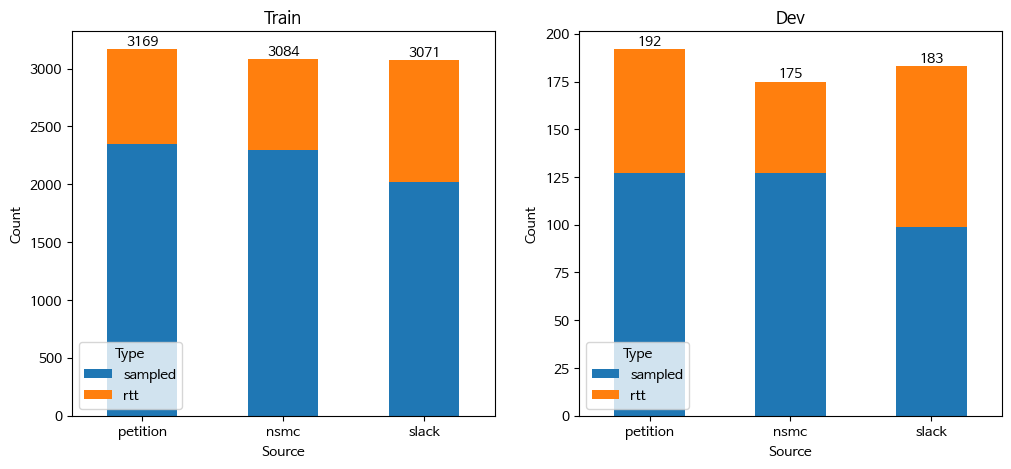

In [11]:
###--- source별 데이터 분포 ---###

# data_train과 data_dev를 각각 변환
result_df_train = source_count(data_train)
result_df_dev = source_count(data_dev)
print("[source별 개수 확인 (train)] ".ljust(60, '-'))
print(result_df_train, '\n')
print("[source별 개수 확인 (dev)] ".ljust(60, '-'))
print(result_df_dev, '\n')

# source별 데이터 분포 시각화
fig, axes = plt.subplots(1, 2, figsize=(12, 5))
source_stacked_bar(result_df_train, "Train", axes[0])
source_stacked_bar(result_df_dev, "Dev", axes[1])
plt.show()

# slack 데이터에서 RTT 비율이 조금 높긴 하지만, 이들 합쳐서는 3개 source에서 데이터 고르게 분포하고 있음

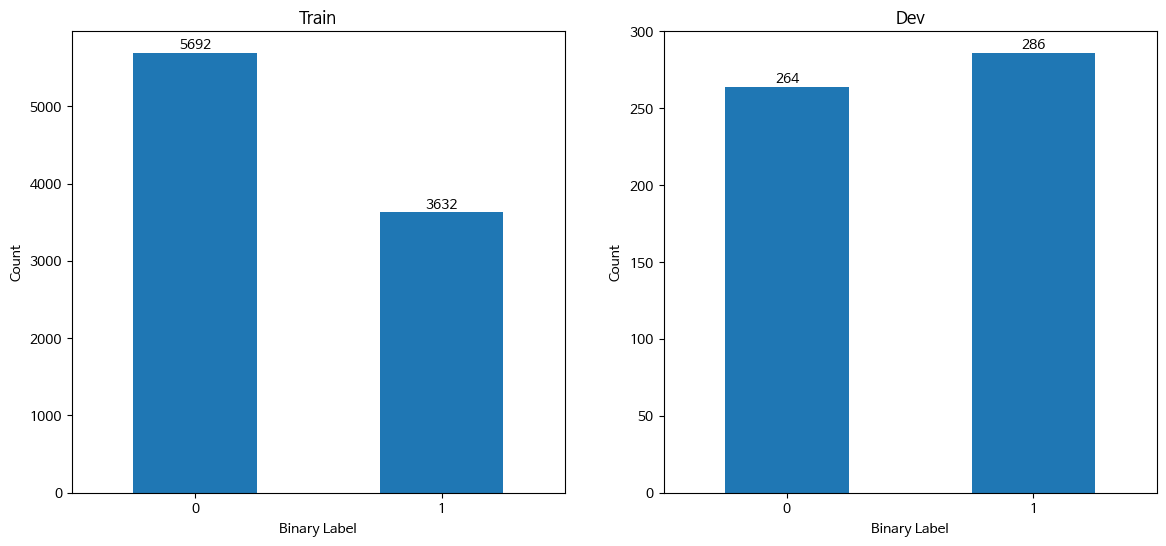

In [12]:
###--- binary-label별 데이터 분포 ---###

# 데이터 집계
train_counts = data_train['binary-label'].value_counts().sort_index()
dev_counts = data_dev['binary-label'].value_counts().sort_index()

# binary-label별 데이터 분포 시각화
fig, axes = plt.subplots(1, 2, figsize=(14, 6))
binarylabel_bar(train_counts, "Train", axes[0])
binarylabel_bar(dev_counts, "Dev", axes[1])
plt.show()

# 최종 성능 평가 시에는 label 활용한 correlation 사용하므로, 더 중요한건 label 수치임.
# binary-label로는 간단한 경향만 확인 가능
#   - train에서 binary 0에 라벨 밀집. dev와는 다른 경향. 
#   - train에서 binary-label=1인 데이터 증강 고려 가능

### 수치형 컬럼 (`label`)
- 분포, 평균, 중앙값, 표준편차, 최소값, 최대값 등

- 5점 : 두 문장의 핵심 내용이 동일하며, 부가적인 내용들도 동일함
- 4점 : 두 문장의 핵심 내용이 동등하며, 부가적인 내용에서는 미미한 차이가 있음
- 3점 : 두 문장의 핵심 내용은 대략적으로 동등하지만, 부가적인 내용에 무시하기 어려운 차이가 있음
- 2점 : 두 문장의 핵심 내용은 동등하지 않지만, 몇 가지 부가적인 내용을 공유함
- 1점 : 두 문장의 핵심 내용은 동등하지 않지만, 비슷한 주제를 다루고 있음
- 0점 : 두 문장의 핵심 내용이 동등하지 않고, 부가적인 내용에서도 공통점이 없음

[label 통계량 (train)] ----------------------------------------
count    9324.000000
mean        1.849968
std         1.602212
min         0.000000
25%         0.200000
50%         1.600000
75%         3.400000
max         5.000000
Name: label, dtype: float64 

[label 통계량 (dev)] ------------------------------------------
count    550.000000
mean       2.584000
std        1.459483
min        0.000000
25%        1.400000
50%        2.600000
75%        3.800000
max        5.000000
Name: label, dtype: float64 



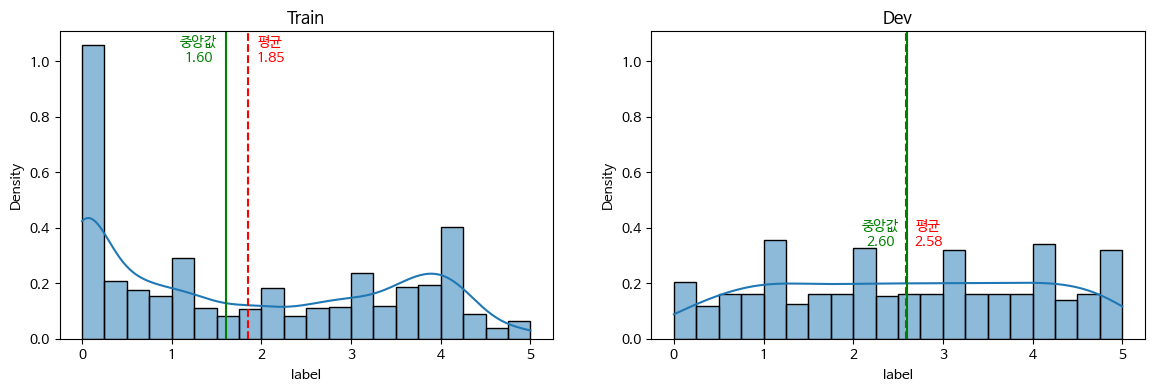

In [13]:
# label 칼럼 확인
print("[label 통계량 (train)] ".ljust(60, '-'))
print(data_train.label.describe(), "\n")
print("[label 통계량 (dev)] ".ljust(60, '-'))
print(data_dev.label.describe(), "\n")

# label별 히스토그램 시각화
fig, axes = plt.subplots(1, 2, figsize=(14, 4))
label_histogram(data_train, 'Train', axes[0])
label_histogram(data_dev, 'Dev', axes[1])
max_y = max(axes[0].get_ylim()[1], axes[1].get_ylim()[1])
axes[0].set_ylim(0, max_y)
axes[1].set_ylim(0, max_y)
plt.show()

# 앞서 binary-label에서도 대략 확인되었던 경향이지만, label 분포에서 데이터 편중이 더 확연히 드러남
# dev 데이터에서는 데이터가 모든 Label에 대해 고르게 분포해있는 반면,
# train 데이터는 상당수 값이 (0, 0.25) 범위에 분포해있음을 확인 가능하다.
#   - label == 0: 2119건 (22.7%)
#   - 0 <= label < 0.25: 2464건 (26.4%)
# 따라서, train 데이터에서 0보다 큰 유사도 값을 갖는 데이터 쌍을 고르게 더 증강할 필요 있음. (how..?)

### 문자형 컬럼 (`sentence_1`, `sentence_2`)
- 문장 길이 분포 및 이상치
- 단어 수 분포 및 이상치
- 문자 종류별 분포(한글/영어/특수문자)
- 기타 정성적 분석

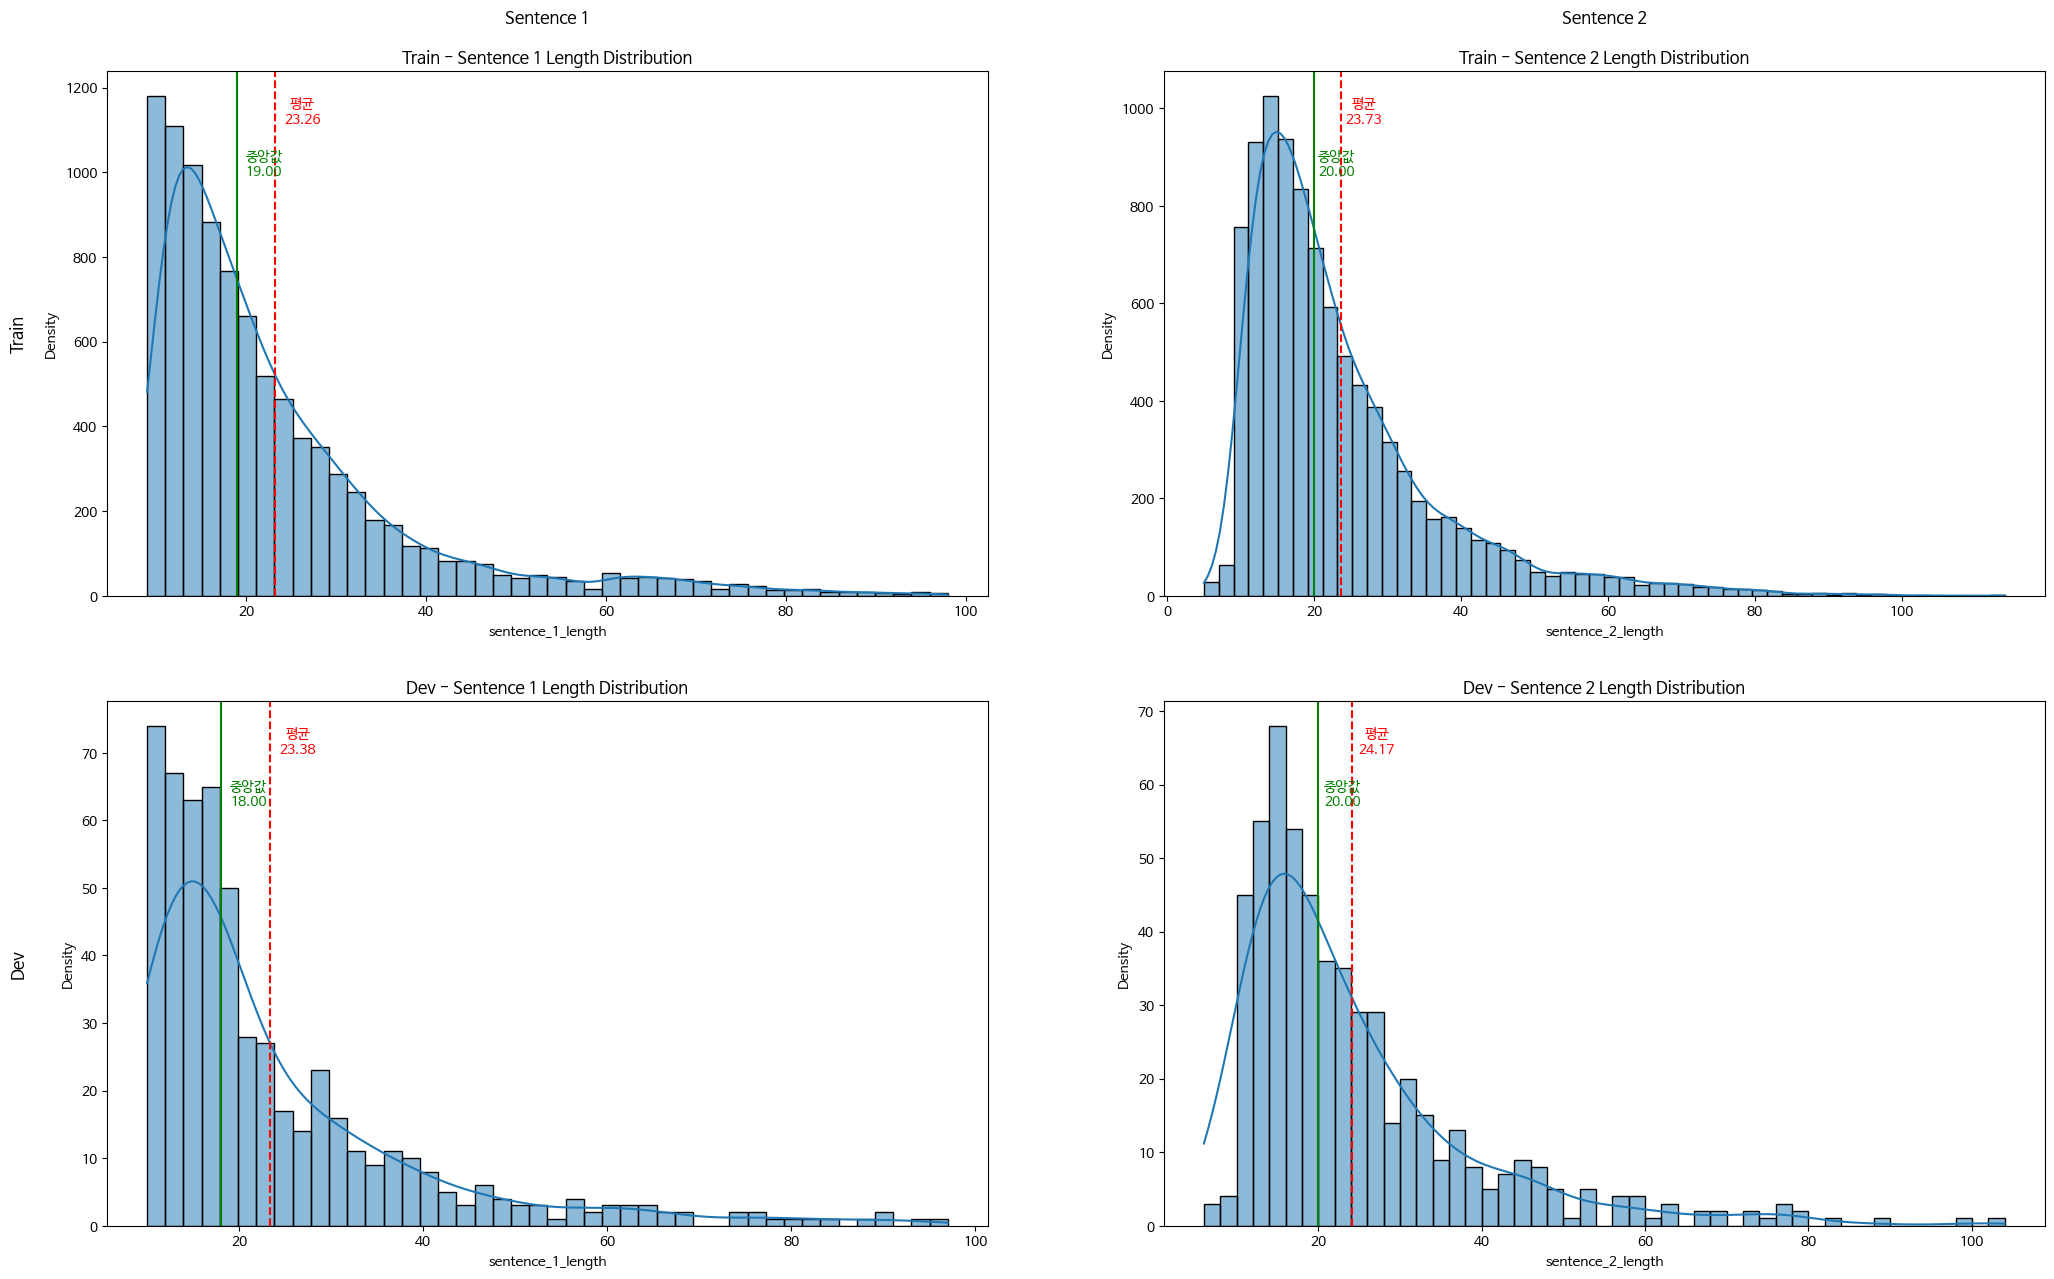

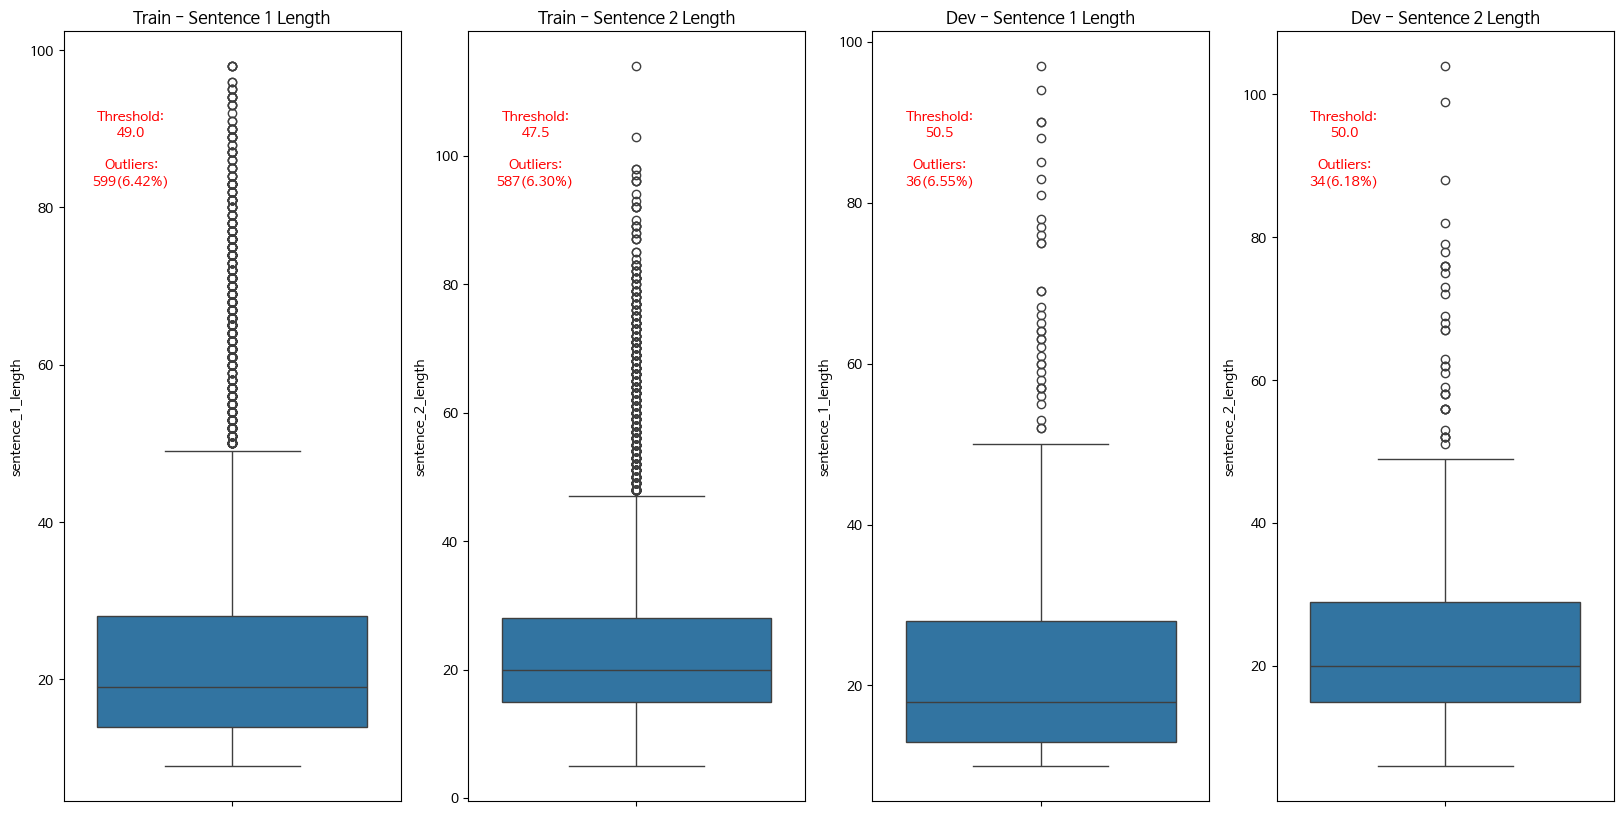

[Kruskal-Wallis 검정 결과] -------------------------------------
H-statistic: 55.68, p-value: 0.00

[50글자 초과하는 문장 비율] ------------------------------------------
Train - sentence 1: 577건 (6.19%)
Train - sentence 2: 484건 (5.19%)
Dev - sentence 1: 36건 (6.55%)
Dev - sentence 2: 34건 (6.18%)


In [14]:
# 문장 길이 분포
data_train['sentence_1_length'] = data_train['sentence_1'].str.len()
data_train['sentence_2_length'] = data_train['sentence_2'].str.len()
data_dev['sentence_1_length'] = data_dev['sentence_1'].str.len()
data_dev['sentence_2_length'] = data_dev['sentence_2'].str.len()

# 문장 길이 분포 시각화
sentence_length_histogram(data_train, data_dev)  # 히스토그램
plot_boxplots_with_outliers(data_train, data_dev, option="sentence_length")  # boxplot
# boxplot이 이상치 확인에 더 용이하므로 이 경우에는 boxplot이 더 나아보임
# 대략 50글자 초과하는 문장은 이상치로 볼 수 있을 듯?

# 4개 분포 유사한지에 대한 비모수 검정
stat, p_value = compare_distributions(data_train['sentence_1_length'], data_train['sentence_2_length'], \
                                      data_dev['sentence_1_length'], data_dev['sentence_2_length'])
print("[Kruskal-Wallis 검정 결과] ".ljust(60, '-'))
print(f"H-statistic: {stat:.2f}, p-value: {p_value:.2f}\n")  # 유사함 (p < 0.05)

# 50글자 초과하는 문장 비율 조회
len_threshold = 50
train_len_1_count, train_len_1_percentage = calculate_outlier_percentage(data_train['sentence_1_length'], 0, len_threshold)
train_len_2_count, train_len_2_percentage = calculate_outlier_percentage(data_train['sentence_2_length'], 0, len_threshold)
dev_len_1_count, dev_len_1_percentage = calculate_outlier_percentage(data_dev['sentence_1_length'], 0, len_threshold)
dev_len_2_count, dev_len_2_percentage = calculate_outlier_percentage(data_dev['sentence_2_length'], 0, len_threshold)
print(f"[{len_threshold}글자 초과하는 문장 비율] ".ljust(60, '-'))
print(f"Train - sentence 1: {train_len_1_count}건 ({train_len_1_percentage:.2f}%)")
print(f"Train - sentence 2: {train_len_2_count}건 ({train_len_2_percentage:.2f}%)")
print(f"Dev - sentence 1: {dev_len_1_count}건 ({dev_len_1_percentage:.2f}%)")
print(f"Dev - sentence 2: {dev_len_2_count}건 ({dev_len_2_percentage:.2f}%)")

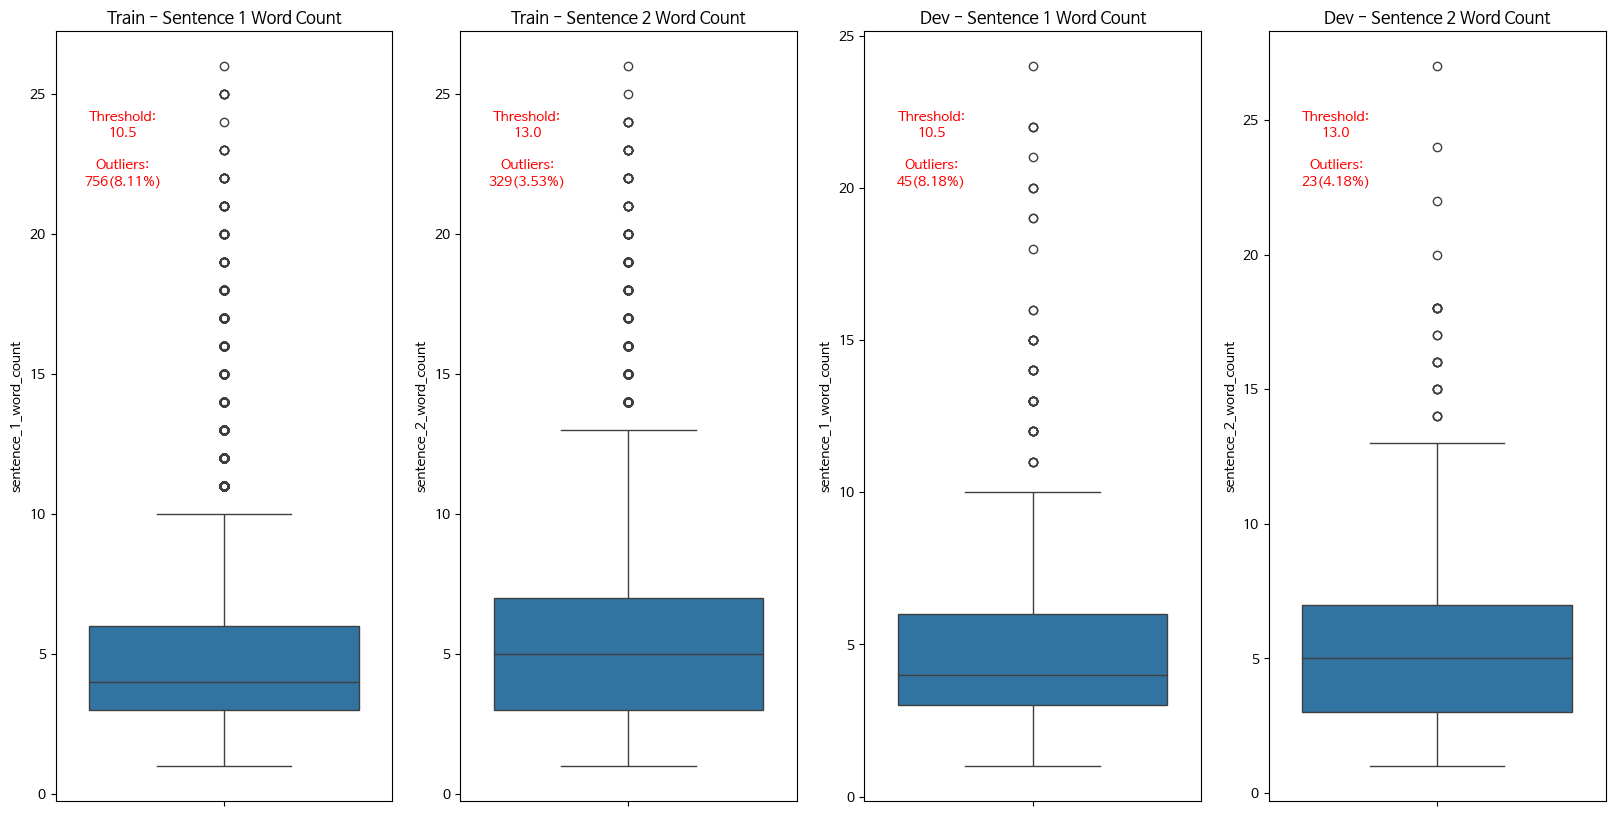

[Kruskal-Wallis 검정 결과] -------------------------------------
H-statistic: 47.09, p-value: 0.00

[13단어 초과하는 문장 비율] ------------------------------------------
Train - sentence 1: 399건 (4.28%)
Train - sentence 2: 329건 (3.53%)
Dev - sentence 1: 25건 (4.55%)
Dev - sentence 2: 23건 (4.18%)


In [15]:
# 단어 개수 분포
data_train['sentence_1_word_count'] = data_train['sentence_1'].str.split().apply(len)
data_train['sentence_2_word_count'] = data_train['sentence_2'].str.split().apply(len)
data_dev['sentence_1_word_count'] = data_dev['sentence_1'].str.split().apply(len)
data_dev['sentence_2_word_count'] = data_dev['sentence_2'].str.split().apply(len)

# 단어 개수 분포 시각화
plot_boxplots_with_outliers(data_train, data_dev, option="word_count")  # boxplot
# 대략 13단어 초과하는 문장은 이상치로 볼 수 있을 듯?

# 4개 분포 유사한지에 대한 비모수 검정
stat_word_count, p_value_word_count = compare_distributions(data_train['sentence_1_word_count'], data_train['sentence_2_word_count'], \
                                      data_dev['sentence_1_word_count'], data_dev['sentence_2_word_count'])
print("[Kruskal-Wallis 검정 결과] ".ljust(60, '-'))
print(f"H-statistic: {stat_word_count:.2f}, p-value: {p_value_word_count:.2f}\n")  # 유사함 (p < 0.05)

# 13단어 초과하는 문장 비율 조회
count_threshold = 13
train_count_1_count, train_count_1_percentage = calculate_outlier_percentage(data_train['sentence_1_word_count'], 0, count_threshold)
train_count_2_count, train_count_2_percentage = calculate_outlier_percentage(data_train['sentence_2_word_count'], 0, count_threshold)
dev_count_1_count, dev_count_1_percentage = calculate_outlier_percentage(data_dev['sentence_1_word_count'], 0, count_threshold)
dev_count_2_count, dev_count_2_percentage = calculate_outlier_percentage(data_dev['sentence_2_word_count'], 0, count_threshold)
print(f"[{count_threshold}단어 초과하는 문장 비율] ".ljust(60, '-'))
print(f"Train - sentence 1: {train_count_1_count}건 ({train_count_1_percentage:.2f}%)")
print(f"Train - sentence 2: {train_count_2_count}건 ({train_count_2_percentage:.2f}%)")
print(f"Dev - sentence 1: {dev_count_1_count}건 ({dev_count_1_percentage:.2f}%)")
print(f"Dev - sentence 2: {dev_count_2_count}건 ({dev_count_2_percentage:.2f}%)")

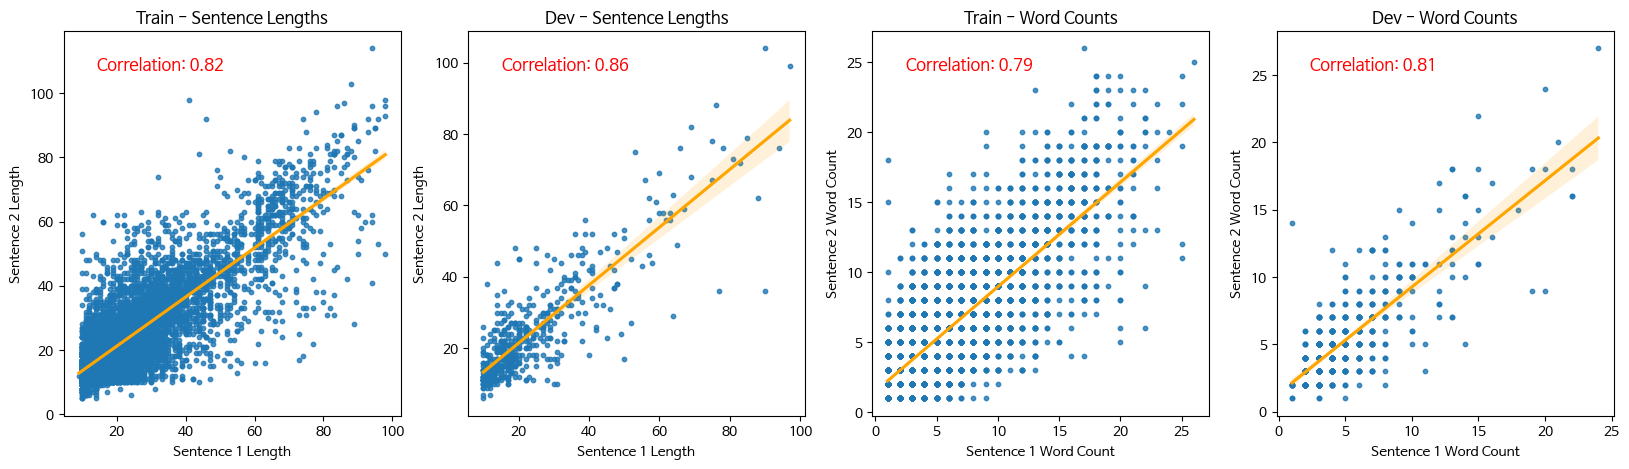

In [16]:
# 상관관계 계산
correlation_len_train = data_train['sentence_1_length'].corr(data_train['sentence_2_length'])
correlation_len_dev = data_dev['sentence_1_length'].corr(data_dev['sentence_2_length'])
correlation_word_count_train = data_train['sentence_1_word_count'].corr(data_train['sentence_2_word_count'])
correlation_word_count_dev = data_dev['sentence_1_word_count'].corr(data_dev['sentence_2_word_count'])

# 상관관계 시각화
fig, axes = plt.subplots(1, 4, figsize=(20, 5))
correlation_plot(data_train, 'Train - Sentence Lengths', 'sentence_length', correlation_len_train, axes[0])
correlation_plot(data_dev, 'Dev - Sentence Lengths', 'sentence_length', correlation_len_dev, axes[1])
correlation_plot(data_train, 'Train - Word Counts', 'word_count', correlation_word_count_train, axes[2])
correlation_plot(data_dev, 'Dev - Word Counts', 'word_count', correlation_word_count_dev, axes[3])
plt.show()

# 이를 통해 sentence_1과 sentence_2의 길이는 서로 상관성이 높음을 알 수 있음 (긴 문장끼리, 짧은 문장끼리 비교되는 경향)
# 이상치 (50자 초과 또는 13개 단어 이상) 데이터를 어떻게 처리할 지 고민 필요 (truncation? 그대로 사용?)

In [17]:
# 이상치 데이터 조회 - 글자수
pd.set_option('display.max_colwidth', None)  # 셀의 모든 내용 출력
sentence_length_threshold = 50
data_train[(data_train['sentence_1_length']>=sentence_length_threshold) & (data_train['sentence_2_length']>=sentence_length_threshold)]\
    [['source','sentence_1','sentence_2','label', 'sentence_1_length', 'sentence_2_length']]\
        .sort_values(by=['sentence_1_length','sentence_2_length'], ascending=False)  # 399건

# 이상치라고는 하지만.. 눈으로 보니 문장 잘라낼 정도로 길지는 않은 듯.

,source,sentence_1,sentence_2,label,sentence_1_length,sentence_2_length
996,petition-rtt,이명박 출국금지 구속수사!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!강력히 요청합니다.,이명박 출국금지 구속 수사!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!! !!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!! 강력히 요청합니다.,5.0,98,98
6669,nsmc-rtt,"소재는 좋았으나 스토리는 많이 아쉽고 감독 연출은 한없이 어설프고 컷컷마다 본인의 메소드 없이, 본 건 많아서 어설프게 배우들 연기 디렉션한거 보면 감독의 자질이 없어 보인다.","소재는 좋았지만 스토리가 너무 실망스러웠고 감독님의 연출이 한없이 서투르고 모든 컷이 자신만의 방식이 없었고, 감독의 자질을 갖추지 못한 듯 보이는 것들이 너무 많았다. .",3.6,98,96
7528,petition-rtt,암호화 화폐(가상화폐) 국회의 입법정책 또는 대통령령으로써 행정입법을 통해 제4차산업의 금융선진화 정책으로 국가미래 산업먹거리에 전문가를 채용하여 정책을 들을 수 있도록합니다.,암호화폐(가상화폐) 국회의 입법정책이나 대통령령으로 행정입법을 통해 국가미래산업식품의 전문가를 고용하여 정책을 들을 수 있도록 하는 4차산업의 재정적 선진화 정책이다.,3.8,98,93
465,petition-rtt,어린이집 유치원 초등학교 중학교 고등학교 각학원에 청원경찰 2명씩 배치 의무화해주시고 등하교시 얼굴인식하도록 의무화해서 기록 남기도록 위반시 벌금 100만원씩 부과토록 해주세요,"어린이집, 유치원, 초등학교, 중학교, 고등학교에 각 학원에 2명의 경찰관을 의무화합니다.",2.8,98,50
3521,nsmc-rtt,같은 남자가 봐도 어처구니 없을 정도로 잘생긴 세기의 미남 배우도 맞춤 옷을 입은 듯한 톰 리플리 라는 배역을 만나지 못했다면 지금의 전설적인 명배우가 되지 못했을 것같다.,같은 남자라도 믿을 수 없을 정도로 잘생긴 세기의 미남 배우라도 맞춤 양복을 입은 듯한 톰 리플리 역을 만나지 않았다면 오늘날의 전설적인 배우가 되지 못했을 것이다.,4.2,96,92
...,...,...,...,...,...,...
7372,nsmc-sampled,볼 수록 빠져드는 마약같은 드라마 1화 부터 24화 까지 심심하지 않은 드라마였던 것 같다.,별로 개연성도 없고... 영화 한 편을 봤는데 두 편 본거 같다. 그것도 재미없는 영화 두편,0.0,51,51
1531,slack-sampled,"이번주 PC팀의 제주도 워크샵 잘 다녀오시길 바라며, 다음에 꼭 또 뵙고 이야기나누어요!!","각자 팀과 진행하고 있는 업무에 대해서도 이야기 나눴고, 다음에 비즈팀 공유 오피스 구경하러 놀러 오시기로! 즐거운 주말 보내세요~~",0.0,50,74
6951,nsmc-rtt,원래 나같은 피터잭슨 매니아들 시선으로는 곱지 않을영화지만 헐리웃 진출작 치고는 나쁘지않음,원래 저 같은 피터잭슨 팬 입장에서 보면 예쁜 영화는 아니겠지만 헐리우드 영화치고는 나쁘지 않습니다.,3.8,50,56
2424,slack-rtt,재택의 장단점 및 워라벨 부터 저의 여러 고민거리들까지 진득하게 이야기하고 사진 찍었습니다,집에 있는 것의 장단점과 직장 라벨부터 제 다양한 고민까지 진지하게 이야기도 하고 사진도 찍었어요.,3.4,50,55


In [18]:
# 이상치 데이터 조회 - 단어수
word_count_threshold = 13
data_train[(data_train['sentence_1_word_count']>=word_count_threshold) & (data_train['sentence_2_word_count']>=word_count_threshold)]\
    [['source','sentence_1','sentence_2','label','sentence_1_word_count','sentence_2_word_count']]\
          .sort_values(by=['sentence_1_word_count','sentence_2_word_count'], ascending=False)  # 313건

,source,sentence_1,sentence_2,label,sentence_1_word_count,sentence_2_word_count
3521,nsmc-rtt,같은 남자가 봐도 어처구니 없을 정도로 잘생긴 세기의 미남 배우도 맞춤 옷을 입은 듯한 톰 리플리 라는 배역을 만나지 못했다면 지금의 전설적인 명배우가 되지 못했을 것같다.,같은 남자라도 믿을 수 없을 정도로 잘생긴 세기의 미남 배우라도 맞춤 양복을 입은 듯한 톰 리플리 역을 만나지 않았다면 오늘날의 전설적인 배우가 되지 못했을 것이다.,4.2,26,25
6669,nsmc-rtt,"소재는 좋았으나 스토리는 많이 아쉽고 감독 연출은 한없이 어설프고 컷컷마다 본인의 메소드 없이, 본 건 많아서 어설프게 배우들 연기 디렉션한거 보면 감독의 자질이 없어 보인다.","소재는 좋았지만 스토리가 너무 실망스러웠고 감독님의 연출이 한없이 서투르고 모든 컷이 자신만의 방식이 없었고, 감독의 자질을 갖추지 못한 듯 보이는 것들이 너무 많았다. .",3.6,25,24
3202,slack-rtt,예시에 작성 주신 것처럼 확실히 파이썬 기초와 AI 수학은 초보자가 넘어가기에는 너무 강력하다는 점을 부트캠프 뿐만 아니라 모든 AI 관련 강의를 들을 때 마다 느낍니다.,예제에서 쓰신 것처럼 파이썬 기초와 AI 수학은 부트캠프뿐만 아니라 모든 AI 관련 강의를 들을 때마다 초보자가 하기에는 너무 강력하다는 것을 확실히 느낍니다.,4.2,25,22
3508,nsmc-rtt,산전 수전 다 겪은 분들이라 입담들도 있으시고 편집을 그렇게 해서 그런지 자칫 지루 할 수도 있는데 한 순간도 그럴 틈이 없이 흥미 진진하게 보고 있습니다.,"출산 전후에 다 겪어봐서 농담도 있고, 그런 식으로 편집해서 그런지 지루할 수도 있지만, 한순간의 여유도 없이 흥미롭게 보고 있다.",3.4,25,19
2342,nsmc-rtt,"인생이라는 긴 여행을 조금이라도 덜 외롭고 힘들지 않게 보내기 위해선 너와 나, 우리 모두는 서로를 가능한 힘껏 안아주고 보듬어 주고 만져주며 살도록 해야 한다.","인생의 긴 여정을 덜 외롭고 힘들게 보내기 위해서는 너와 나, 우리 모두가 서로를 최대한 끌어안고, 애무하고, 만질 수 있어야 한다.",3.4,24,20
...,...,...,...,...,...,...
4545,slack-sampled,"모델이 경쟁력이 아니라, 모델의 편의성이 경쟁력이 되는 시점임을 명확하게 인지하고 있는 것 같습니다.",이런 점을 방지하기 위해 AI 모델에도 UX적인 관점이 필요하다는게 명확해지고 있는 것 같습니다,0.2,13,13
4852,slack-sampled,"코로나에 대한 이야기도 하고, 제가 런닝을 ~하다말다~ 하고 있어서 런닝에 대한 조언도 받았습니다.",서로 전공 이야기도 하고 업무 이야기도 했지만 무엇보다 올스타전에 대한 기대가 가장 컸네요!,0.0,13,13
6358,nsmc-rtt,일후 보다 빨라진 좀비 + 새벽의 황당한 저주 스토리를 웃음끼 싹빼고 각색한영화라고 보믄됨..,퇴근 후보다 빠른 좀비 + 터무니없는 새벽의 저주 이야기는 웃음없이 영화의 각색으로 보였다..,3.0,13,13
6765,slack-rtt,저도 아카펠라 좋아해서 이 그룹 간간히 찾아서 듣는데 개인적으로 윈도우 사운드 아카펠라가 압권!!,저도 아카펠라를 좋아해서 가끔 이 그룹을 찾아서 듣지만 개인적으로는 윈도우 사운드 아카펠라가 최고!!,4.2,13,13


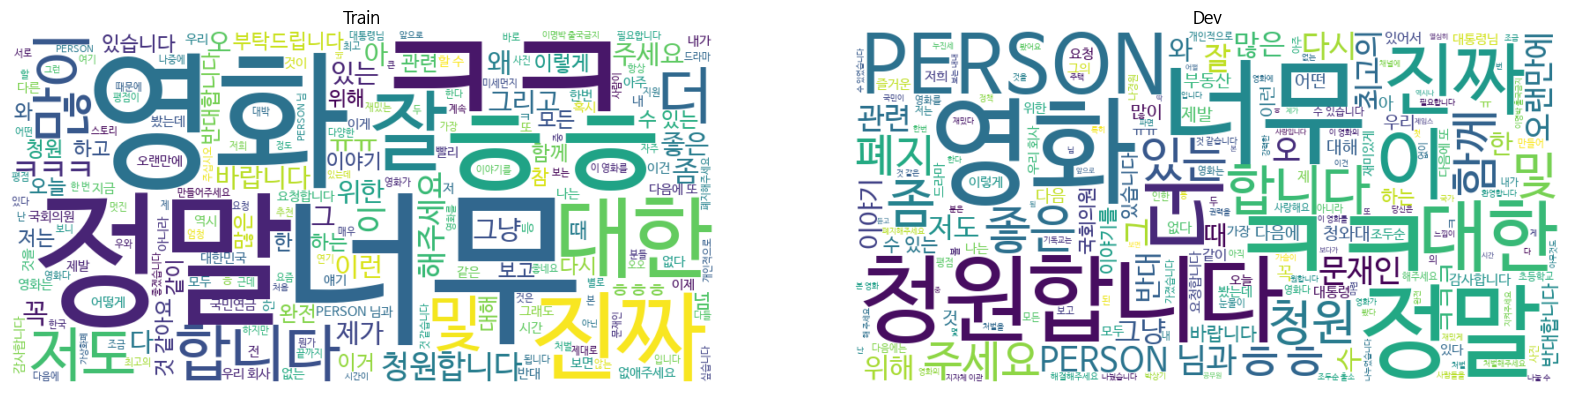

In [19]:
# 단어 수 분포 확인

# 두 문장 결합
all_text_train = ' '.join(data_train['sentence_1'] + ' ' + data_train['sentence_2'])
all_text_dev = ' '.join(data_dev['sentence_1'] + ' ' + data_dev['sentence_2'])

# 워드클라우드 시각화
plot_wordclouds(all_text_train, all_text_dev, font_path)

# 단어 등장 빈도 count (rough하게, 띄어쓰기 기준으로 단어 확인함)
word_freq_train = Counter(all_text_train.split())
word_freq_dev = Counter(all_text_dev.split())
train_word_freq_df = pd.DataFrame(word_freq_train.items(), columns=['word', 'frequency']).sort_values(by='frequency', ascending=False)
dev_word_freq_df = pd.DataFrame(word_freq_dev.items(), columns=['word', 'frequency']).sort_values(by='frequency', ascending=False)

In [20]:
# train 데이터의 상위 빈도 등장 단어
train_word_freq_df.head(30)

# 이것만 보고 뭔가 유의미한 결론 내리기는 힘들 것 같음.. 흠... 
# 이걸 통해 뭘 말할 수 있을까?

,word,frequency
85,너무,689
74,수,530
32,정말,469
440,ㅋㅋ,385
306,영화,323
188,것,323
336,이,288
225,ㅎㅎ,286
212,진짜,280
496,대한,278


In [21]:
# dev 데이터의 상위 빈도 등장 단어
dev_word_freq_df.head(30)

,word,frequency
12,너무,36
46,ㅋㅋ,35
214,수,33
19,영화,28
225,정말,26
130,이,25
68,<PERSON>,24
169,있는,23
956,더,21
188,것,18


In [22]:
# 문자 종류별 분포 - EDA이므로 대략적인 기준만 적당히 세움. 경향성만 확인.
# 한글이나 영어 아닌 문자 포함하면 special_chars
# 영어 포함하면 english_words
# 한글 포함하면 korean_words

# (train 데이터 기준)
english_words, korean_words, special_chars, etc = categorize_words(all_text_train)

# Calculate proportions
total_words = len(english_words) + len(korean_words) + len(special_chars) + len(etc)
english_ratio = len(english_words) / total_words * 100
korean_ratio = len(korean_words) / total_words * 100
special_ratio = len(special_chars) / total_words * 100
etc_ratio = len(etc) / total_words * 100

# Display proportions
print(f"English words: {english_ratio:.2f}%")
print(f"Korean words: {korean_ratio:.2f}%")
print(f"Special characters: {special_ratio:.2f}%")
print(f"ETC characters: {etc_ratio:.2f}%")


# Count frequencies
english_freq = Counter(english_words).most_common()
korean_freq = Counter(korean_words).most_common()
special_freq = Counter(special_chars).most_common()

# Create DataFrames
english_df = pd.DataFrame(english_freq, columns=['Word', 'Frequency'])
korean_df = pd.DataFrame(korean_freq, columns=['Word', 'Frequency'])
special_df = pd.DataFrame(special_freq, columns=['Character', 'Frequency'])

English words: 0.64%
Korean words: 80.13%
Special characters: 19.23%
ETC characters: 0.00%


In [23]:
english_df

,Word,Frequency
0,AI,19
1,DM,10
2,B급,9
3,pc방,8
4,tv,7
...,...,...
493,사당동pc방살인사건,1
494,sns,1
495,cg를,1
496,CG를,1


In [24]:
korean_df

,Word,Frequency
0,너무,689
1,수,530
2,정말,469
3,것,323
4,영화,323
...,...,...
32693,못먹은,1
32694,먹기로,1
32695,휴무관련,1
32696,법정공휴일의,1


In [25]:
special_df

,Character,Frequency
0,ㅋㅋ,385
1,ㅎㅎ,286
2,<PERSON>,222
3,합니다.,162
4,ㅋㅋㅋ,151
...,...,...
12302,7-10일,1
12303,가고싶은집!!,1
12304,검토하십시오.,1
12305,하고요!!,1


# 3. Source 별 데이터 특성
1. source 별 label 분포
2. source별 sentence 특성
    - 문장 길이 분포 및 이상치
    - 단어 수 분포 및 이상치
    - 문자 종류별 분포(한글/영어/특수문자)
    - 기타 정성적 분석

#### 함수 정의

In [26]:
def plot_label_statistics(data_train, data_dev):
    # Extract main source category
    data_train['main_source'] = data_train['source'].str.split('-').str[0]
    data_dev['main_source'] = data_dev['source'].str.split('-').str[0]

    # Create subplots
    fig, axes = plt.subplots(2, 2, figsize=(14, 10))

    # Train data by source
    sns.boxplot(data=data_train, x='source', y='label', ax=axes[0, 0], order=sorted(data_train['source'].unique()))
    axes[0, 0].set_title('Train - Label by Source')
    axes[0, 0].set_xticks(range(len(data_train['source'].unique())))
    axes[0, 0].set_xticklabels(sorted(data_train['source'].unique()), rotation=45)

    # Dev data by source
    sns.boxplot(data=data_dev, x='source', y='label', ax=axes[0, 1], order=sorted(data_dev['source'].unique()))
    axes[0, 1].set_title('Dev - Label by Source')
    axes[0, 1].set_xticks(range(len(data_dev['source'].unique())))
    axes[0, 1].set_xticklabels(sorted(data_dev['source'].unique()), rotation=45)

    # Train data by main source
    sns.boxplot(data=data_train, x='main_source', y='label', ax=axes[1, 0], order=sorted(data_train['main_source'].unique()))
    axes[1, 0].set_title('Train - Label by Main Source')
    axes[1, 0].set_xticks(range(len(data_train['main_source'].unique())))
    axes[1, 0].set_xticklabels(sorted(data_train['main_source'].unique()), rotation=45)

    # Dev data by main source
    sns.boxplot(data=data_dev, x='main_source', y='label', ax=axes[1, 1], order=sorted(data_dev['main_source'].unique()))
    axes[1, 1].set_title('Dev - Label by Main Source')
    axes[1, 1].set_xticks(range(len(data_dev['main_source'].unique())))
    axes[1, 1].set_xticklabels(sorted(data_dev['main_source'].unique()), rotation=45)

    plt.tight_layout()
    plt.show()

#### 분석

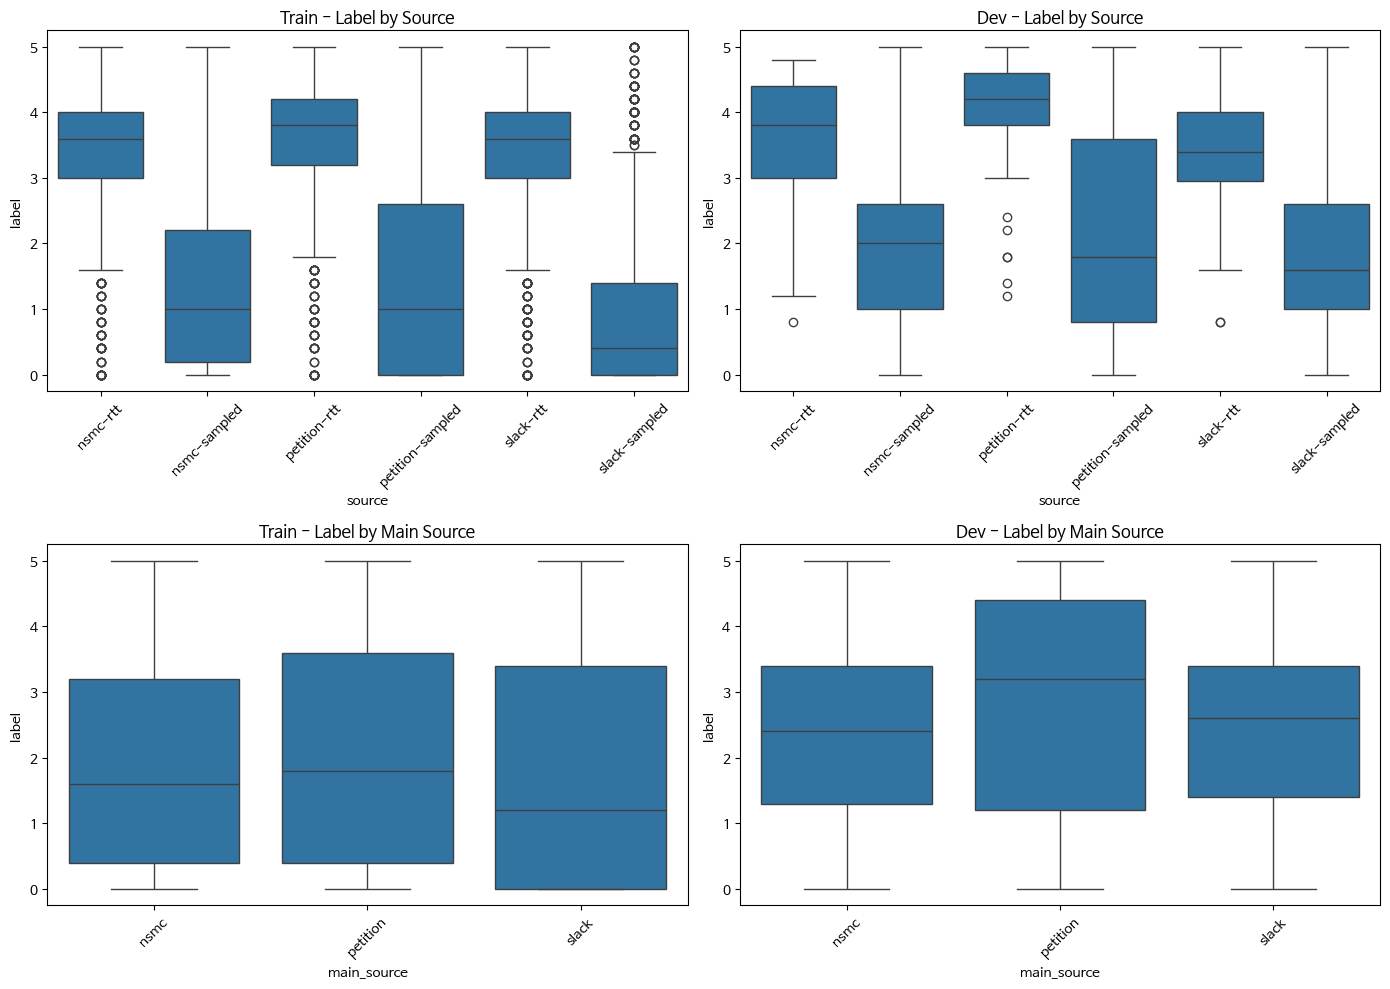

In [27]:
# main source 칼럼 생성
data_train['main_source'] = data_train['source'].str.split('-').str[0]
data_dev['main_source'] = data_dev['source'].str.split('-').str[0]

# Source 별 label 통계 및 시각화
plot_label_statistics(data_train, data_dev)

In [28]:
label_stats_source_train = data_train.groupby('source')['label'].agg(['mean', 'median', 'std'])
print("Label Statistics by Source (train):\n", label_stats_source_train, '\n')

label_stats_source_dev = data_dev.groupby('source')['label'].agg(['mean', 'median', 'std'])
print("Label Statistics by Source (dev):\n", label_stats_source_dev)

Label Statistics by Source (train):
                       mean  median       std
source                                      
nsmc-rtt          3.303426     3.6  1.047706
nsmc-sampled      1.323476     1.0  1.277747
petition-rtt      3.590208     3.8  1.048120
petition-sampled  1.436692     1.0  1.472262
slack-rtt         3.364088     3.6  1.010173
slack-sampled     0.875889     0.4  1.169011 

Label Statistics by Source (dev):
                       mean  median       std
source                                      
nsmc-rtt          3.625000     3.8  0.959277
nsmc-sampled      1.919685     2.0  1.088835
petition-rtt      4.027692     4.2  0.876518
petition-sampled  2.188189     1.8  1.618672
slack-rtt         3.398810     3.4  0.954948
slack-sampled     1.800000     1.6  1.202633


/tmp/ipykernel_319771/3449199781.py:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  label_stats_source_train = data_train.groupby('source')['label'].agg(['mean', 'median', 'std'])
/tmp/ipykernel_319771/3449199781.py:4: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  label_stats_source_dev = data_dev.groupby('source')['label'].agg(['mean', 'median', 'std'])


In [29]:
label_stats_mainsource_train = data_train.groupby('main_source')['label'].agg(['mean', 'median', 'std'])
print("Label Statistics by Main Source (dev):\n", label_stats_mainsource_train, '\n')

label_stats_mainsource_dev = data_dev.groupby('main_source')['label'].agg(['mean', 'median', 'std'])
print("Label Statistics by Main Source (dev):\n", label_stats_mainsource_dev)

Label Statistics by Main Source (dev):
                  mean  median       std
main_source                            
nsmc         1.829377     1.6  1.497170
petition     1.991890     1.8  1.667089
slack        1.724194     1.2  1.624743 

Label Statistics by Main Source (dev):
                  mean  median       std
main_source                            
nsmc         2.387429     2.4  1.299718
petition     2.810938     3.2  1.657581
slack        2.533880     2.6  1.353851


# 4. label별 데이터 특성

In [30]:
# 데이터프레임 나누기
data_0_1 = data_train[data_train['label'] < 1]
data_1_2 = data_train[(data_train['label'] >= 1) & (data_train['label'] < 2)]
data_2_3 = data_train[(data_train['label'] >= 2) & (data_train['label'] < 3)]
data_3_4 = data_train[(data_train['label'] >= 3) & (data_train['label'] < 4)]
data_4_5 = data_train[data_train['label'] >= 4]

# 랜덤 샘플링 - 점수별 text 예시 확인하기 
sample_0_1 = data_0_1.sample(n=20, random_state=1)
sample_1_2 = data_1_2.sample(n=20, random_state=1)
sample_2_3 = data_2_3.sample(n=20, random_state=1)
sample_3_4 = data_3_4.sample(n=20, random_state=1)
sample_4_5 = data_4_5.sample(n=20, random_state=1)

- 5점 : 두 문장의 핵심 내용이 동일하며, 부가적인 내용들도 동일함
- 4점 : 두 문장의 핵심 내용이 동등하며, 부가적인 내용에서는 미미한 차이가 있음
- 3점 : 두 문장의 핵심 내용은 대략적으로 동등하지만, 부가적인 내용에 무시하기 어려운 차이가 있음
- 2점 : 두 문장의 핵심 내용은 동등하지 않지만, 몇 가지 부가적인 내용을 공유함
- 1점 : 두 문장의 핵심 내용은 동등하지 않지만, 비슷한 주제를 다루고 있음
- 0점 : 두 문장의 핵심 내용이 동등하지 않고, 부가적인 내용에서도 공통점이 없음

In [31]:
sample_0_1[['sentence_1', 'sentence_2']]   # 모아서 보니 점수 기준 납득됨.. 

,sentence_1,sentence_2
5536,유아교육과 정교사 자격증 관련,유치원및 어린이집교사 유아교육전공자 처우개선
8394,전임 대통령을 용서해주세요,이명박 전 대통령 출국 금지 시켜주세요
8405,정말 말도 안되게 에너지 부글부글한 이상한 영화....,너무나 달달한 영화...
7859,현재 올려주신 내용을 토대로 ver1.1 페이지를 만들었습니다.,오늘 점심에 <PERSON> 님과 1:1 식사를 했습니다.
4531,제가 호스트하니 시간되시면 오셔도 좋습니다.,근처 오시면 무조건 차 대접 드립니다.
239,이렇게 가슴을 답답하게 만드는 영화가 있었나?,드라마가 전달해준 메세지가 가슴을 찡하게 합니다.
3950,이 영화 때문인건가...,정말 비극적이네....
5675,조편성은 랜덤일까요~?,텀을 조금 길게해도 되지않을까요~?!
8348,"초반엔 스펙타클 하지만, 결국은 빛좋은 개살구 ..",하지만 영상미는 좋은편...
8625,저도 그럼 3km부터 소소하게 연습해봐야겠어요,저도 괜찮으면 돈 내가면서 사용해봐야겠네요.
